In [1]:
load("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/7_clusters/workspace.RData")

In [2]:
source("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/core_functions.R")
load_data(normalise=TRUE)

library(Matrix)
library(umap)
library(reticulate)
library(biomaRt)
library(ggplot2)
library(knitr)
library(scales)
library(viridis)
library(cowplot)

Loading required package: Matrix


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: scran

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:Matrix’:

    which


The following objects are masked from ‘package:stats’:

    IQR

# Final QC Check (odds and ends)

In [3]:
counts<-counts(sce)
t.matrix<-t(counts)

In [4]:
t.finalMatrix<- t.matrix[which(meta$doublet == FALSE & meta$stripped==FALSE),]

In [5]:
final_Matrix<-t(t.finalMatrix)
ncol(final_Matrix)

[1] 146133

In [7]:
lib.sizes = Matrix::colSums(final_Matrix)

ngenes = Matrix::colSums(final_Matrix > 0)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3501    6923   10126   12326   14811  121907 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    905    2070    2661    2772    3315    7257 

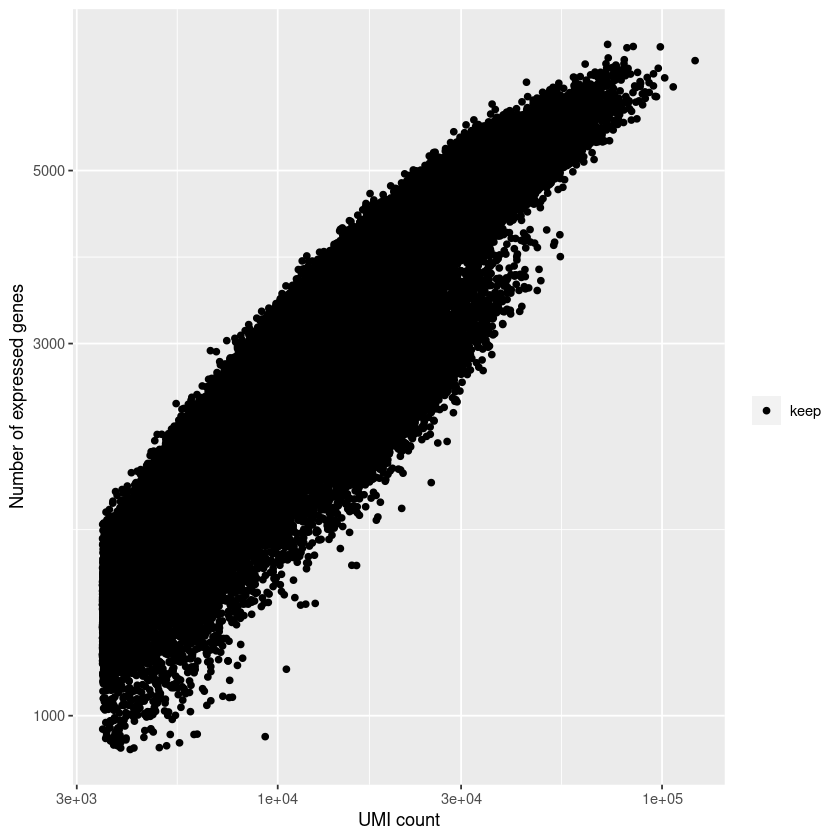

In [8]:
library(ggplot2)


qplot(lib.sizes, ngenes, col = ifelse(ngenes < 900, "drop", "keep")) +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "UMI count", y = "Number of expressed genes") +
  scale_color_manual(values = c("drop" = "grey50", "keep" = "black"), name = "")

summary(lib.sizes)
summary(ngenes)

In [12]:
subset_meta<-meta[which(meta$doublet == FALSE & meta$stripped==FALSE),]

median(ngenes[subset_meta$sample==1])
median(lib.sizes[subset_meta$sample==1])

[1] 3000

[1] 12689

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




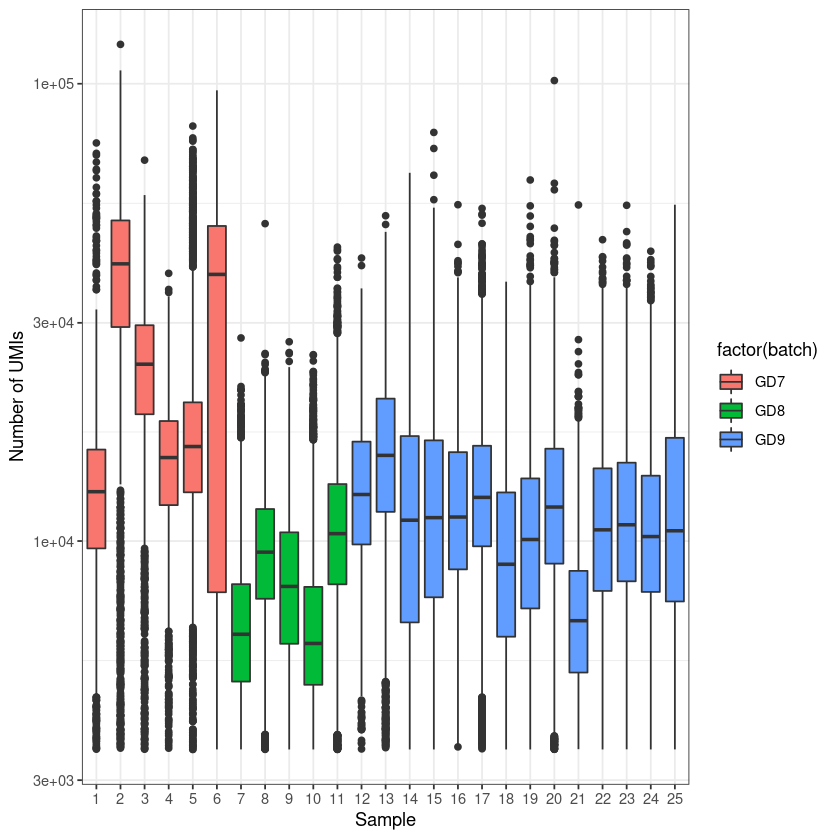

In [13]:


barcodes = read.table("/rds/project/bg200/rds-bg200-hphi-gottgens/users/mlnt2/PhD_MT06/2_cellcalling/barcodes_trimmed.tsv", stringsAsFactors = F)[,1]
barcodes = barcodes[which(meta$doublet == FALSE & meta$stripped==FALSE)]

split_bc = strsplit(as.character(barcodes), "-", fixed = T)
bcs = sapply(split_bc, function(x) x[1])
samples = sapply(split_bc, function(x) x[2])

batch = sapply(samples, function(x){
  if(x %in% 1:6){
    return('GD7')
  } else if(x %in% 7:11) {
    return('GD8')
  } else {
    return('GD9')
  }
})
                 
p = ggplot(data.frame(lib = lib.sizes, sample = samples), aes (x = factor(sample, levels = unique(sample)), 
                                                           y = lib.sizes, fill = factor(batch))) +
  geom_boxplot() +
  theme_bw() +
  scale_y_log10() +
  labs(x = "Sample", y = "Number of UMIs")+
  scale_color_brewer(palette = "Set1", name = "Sequencing\nbatch")

suppressWarnings(plot(p))

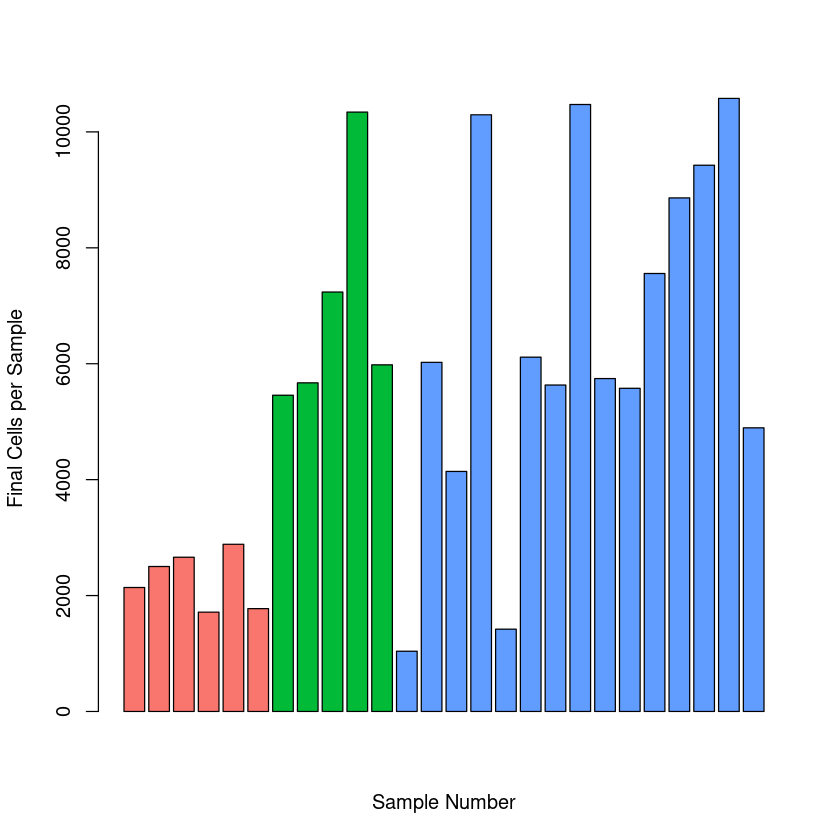

In [16]:
final_cells_per_sample = c(2139,2501,2661,1714,
                     2885,1774,5456,5670,
                     7237,10342,5981,1039,
                     6024,4142,10295,1420,
                     6113,5632,10473,5744,
                     5576,7557,8861,9425,
                     10578,4894)

groups = c(rep('#f8766d', 6),
           rep('#00ba38', 5),
           rep('#619cff', 15))

barplot(final_cells_per_sample, col=groups, xlab = 'Sample Number', ylab = 'Final Cells per Sample')


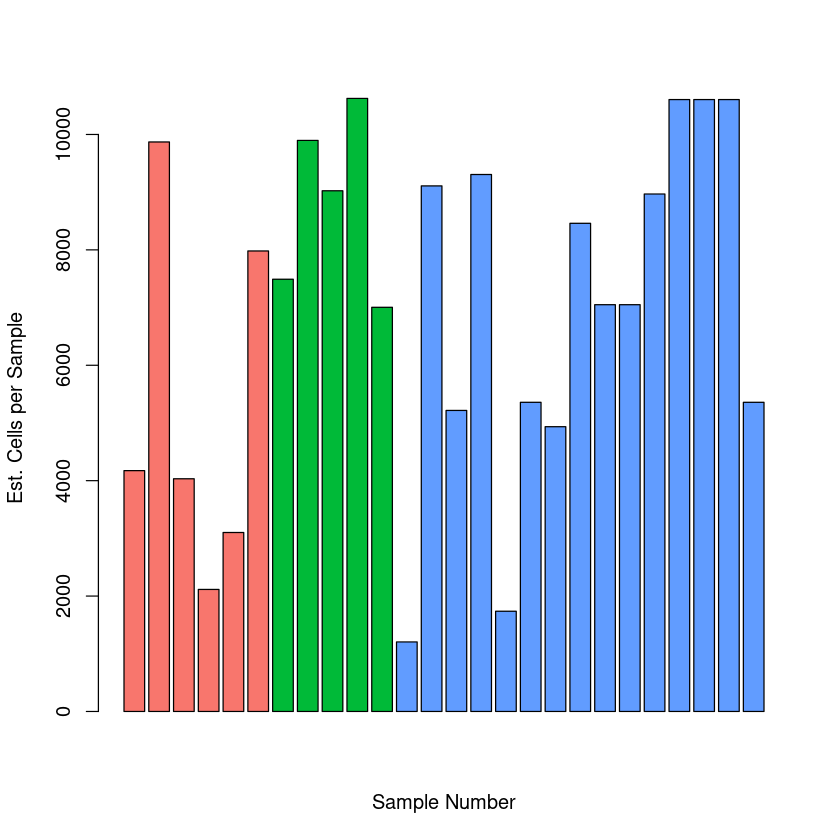

In [17]:
est_cells_per_sample = c(4174,9870,4033,2115,3102,7981,7491,9897,9024,10625,
                         7005,1205,9109,5217,9306,1737,5358,4935,8460,7050,
                         7050,8968,10605,10605,10605,5358)

groups = c(rep('#f8766d', 6),
           rep('#00ba38', 5),
           rep('#619cff', 15))

barplot(est_cells_per_sample, col=groups, xlab = 'Sample Number', ylab = 'Est. Cells per Sample')


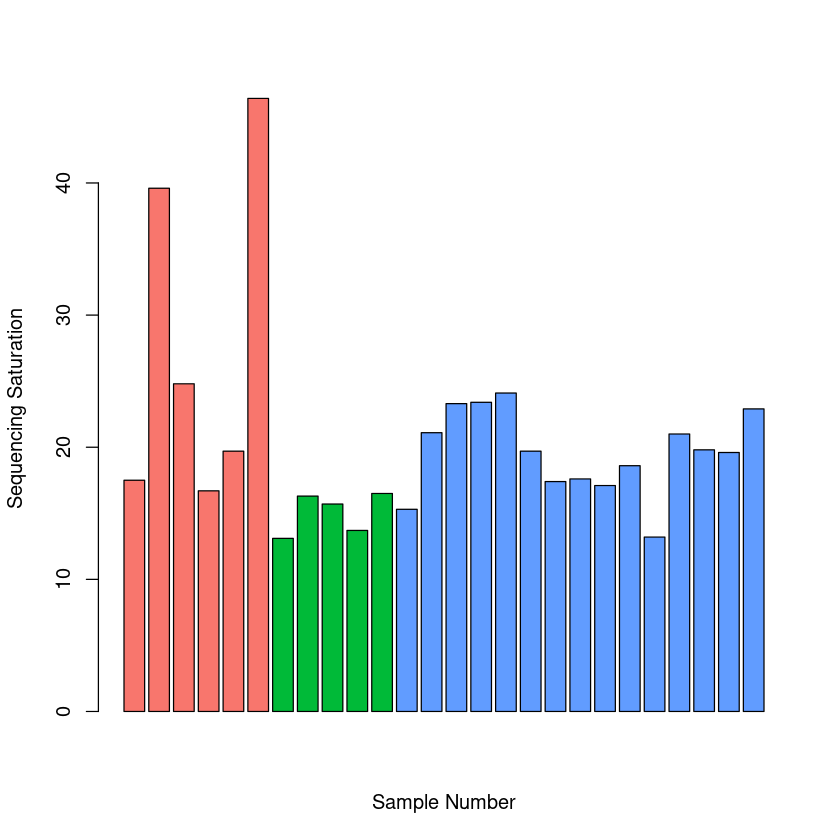

In [18]:
seq_sat = c(
17.50,
39.60,
24.80,
16.70,
19.70,
46.40,
13.10,
16.30,
15.70,
13.70,
16.50,
15.30,
21.10,
23.30,
23.40,
24.10,
19.70,
17.40,
17.60,
17.10,
18.60,
13.20,
21.00,
19.80,
19.60,
22.90)

groups = c(rep('#f8766d', 6),
           rep('#00ba38', 5),
           rep('#619cff', 15))

barplot(seq_sat, col=groups, xlab = 'Sample Number', ylab = 'Sequencing Saturation')


# ANOVA

Understanding variation in UMI numbers per sample

In [24]:
med_UMI = c(12689,
41948,
25507,
15102,
15391,
44793,
5951.5,
9549.5,
8953,
5536,
9653,
8282,
12333,
17347.5,
9651,
16182,
11664,
12607.5,
8294,
11257,
12449,
6731,
11177,
10616,
9963.5,
12462.5)

med_gene = c(3000,
5160,
4107,
3250.5,
3268,
5104.5,
1829,
2456,
2359,
1727,
2428,
2650,
3298.5,
3836,
2526,
3921.5,
3312,
3367,
2287,
2976,
3132,
1845,
2908,
2805,
2706,
2367)


In [47]:
df = data.frame(final_cells_per_sample, est_cells_per_sample, seq_sat, med_gene)
df


final_cells_per_sample,est_cells_per_sample,seq_sat,med_gene
<dbl>,<dbl>,<dbl>,<dbl>
2139,4174,17.5,3000.0
2501,9870,39.6,5160.0
2661,4033,24.8,4107.0
1714,2115,16.7,3250.5
2885,3102,19.7,3268.0
1774,7981,46.4,5104.5
5456,7491,13.1,1829.0
5670,9897,16.3,2456.0
7237,9024,15.7,2359.0


In [50]:
# pearson's correlation between med_gene and variables

cor(med_UMI, df)

cor(final_cells_per_sample,seq_sat)

final_cells_per_sample,est_cells_per_sample,seq_sat,med_gene
-0.5274549,-0.05215369,0.9446479,0.9085


[1] -0.3559082

In [37]:
summary(aov(med_UMI ~ est_cells_per_sample + final_cells_per_sample, data = df))

                       Df    Sum Sq   Mean Sq F value   Pr(>F)    
est_cells_per_sample    1 6.197e+06 6.197e+06   0.148    0.704    
final_cells_per_sample  1 1.309e+09 1.309e+09  31.287 1.08e-05 ***
Residuals              23 9.626e+08 4.185e+07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [5]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("mygene")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'mygene'

also installing the dependencies ‘gsubfn’, ‘proto’, ‘chron’, ‘sqldf’


Installation path not writeable, unable to update packages: boot, class,
  KernSmooth, lattice, MASS, Matrix, mgcv, nnet, spatial

Old packages: 'ape', 'backports', 'dbplyr', 'DelayedArray', 'devtools',
  'dplyr', 'ellipsis', 'fitdistrplus', 'future', 'future.apply', 'ggplot2',
  'git2r', 'glue', 'HDF5Array', 'httpuv', 'isoband', 'later', 'nlme', 'pillar',
  'pkgbuild', 'pkgload', 'plotrix', 'ps', 'purrr', 'RcppArmadillo', 'RCurl',
  'rematch2', 'reshape2', 'reticulate', 'rex', 'rlang', 'ROCR', 'rversions',
  'S4Vectors', 'scales', 'Seurat', 'Signac', 'sn', 'survival', 'tibble',
  'tidyr', 'tidyselect', 'usethis', 'vctrs', 'withr', 'xfun', 'xml2', 'zoo'



In [7]:
library("mygenes")

ERROR: Error in library("mygenes"): there is no package called ‘mygenes’


# Matrix Manipulation test for shinyApp